# Predicting motions from EEG readings

This notebook provides all code needed to process the data from the Kaggle EEG-grasp-and-lift competition, build a model, and train it. There are additional functions for visualising the data too. Play around and see if you can beat my best scores on the validation set (scroll down to see them).

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as auc
from scipy.interpolate import spline

In [ ]:
# set to 0 if not running on GPU
USE_CUDA = 1

# Quicly Looking at the CSV files

LEt's load some CSVs so we can see how they are formatted... There are two CSVs for each series, showing the data and the events. A quick look at the CSVs and we can see there are 32 readings for each time frame, and then in the events csv we have 6 labels columns that will be 0 or 1 depending on whether the action is occurring.

In [7]:
PATH = '/floyd/input/data/'
data = pd.read_csv(f'{PATH}train/subj1_series1_data.csv')
ev = pd.read_csv(f'{PATH}/train/subj1_series1_events.csv')

In [8]:
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


# Diagram showing where 32 readings above were taken from
<img src="images/EEGsetup.jpeg">

In [9]:
ev.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


# Reading the data

The below function reads each csv in the train directory, and stacks them into two numpy matrices. One with the readings from the EEG (self.data) and one with the corresponding class labels (self.target).

In [17]:
class eegdata(Dataset):
    
    def __init__(self, path, validation=False, subjects=range(1,13)):
        super().__init__()
        data, self.target = self.readfiles(path, validation, subjects)
        self.mean= data.mean(axis=0)
        self.std = data.std(axis=0)
        self.data = self.norm(data)
    
    def norm(self, x):
        return ((x - self.mean)/self.std)
    
    def to_np(self, values):
        
        #get total lines of data count
        count = 0
        for i in range(len(values)):
            count += len(values[i])
        
        #create np array size of all data
        ret = np.zeros((count, len(values[0][0])))
        
        #copy data into np array 
        ix = 0
        for i in range(len(values)):
            ret[ix:ix+len(values[i]), :] = values[i]
            ix += len(values[i])
        return ret
        
    
    def readfiles(self, path, validation, subjects):
        
        allx = []
        ally = []
        
        series = [1,2,4,5,6,7,8] if validation == False else [3]
        
        for i in subjects:
            print('log: reading subject {}...'.format(i))
            xs = None
            ys = None
            for j in series:

                data = 'subj{}_series{}_data.csv'.format(i,j)
                events = 'subj{}_series{}_events.csv'.format(i,j)

                x = pd.read_csv(path + data).values[:, 1:]
                xs = x if xs is None else np.vstack((xs, x))

                y = pd.read_csv(path + events).values[:, 1:]
                ys = y if ys is None else np.vstack((ys, y))

            allx.append(xs)
            ally.append(ys)

        xs = self.to_np(allx)
        ys = self.to_np(ally)

        return xs, ys
                    
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]
        
    def __len__(self):
        return len(self.data)
                    

In [ ]:
# load subjects data into one big array using object created above
# if not enough RAM is available, only load some subjects at a time, and train on these subjects seperately
# i.e. train on subjects 1-4, then 5-8, then 9-12. Here the code starts off by loading up subjects 1-4 only.

subjects=range(1,5)
traindata = eegdata(f'{PATH}train/', subjects=subjects)
valdata = eegdata(f'{PATH}train/', validation=True)

In [ ]:
# also create individual datasets for subjects, we will use this now for visualising data, and later 
# for finetuning the model on the individuals. If not enough RAM, skip this step until you have finished training
# on all subjects.

def get_individuals(individuals=range(1,5)):
          
    subjects = []
    vals = []

    for i in individuals:
    
        s = [i]
        subject = eegdata(f'{PATH}train/', subjects=s)
        v = eegdata(f'{PATH}train/', validation=True, subjects=s)
        subjects.append(subject)
        vals.append(v)
        
    return subjects, vals

In [ ]:
subjects, vals = get_individuals()

# Visualising the data

The below functions let you pick an event and a subject and see how the 32 voltage channels readings change over a time window of 200ms before the event until 300ms after.

To begin looking at the data I picked the first event 'HandStart'. This refers to when a light flashes,  telling the subject to begin the grasp and lift. Looking at the first subject, this figure shows how the 32 values changed during the time window.

<img src="images/32waves.jpeg">

Already we can see a pattern and if we average all the 32 values, it suddenly becomes much more clear.

<img src="images/subj1wave.jpeg">

It seems HandStart is accompanied by a general lowering of the overall voltage readings followed by a spike. The model should be able to recognise these patterns when making predictions. Importantly, the data has a similar shape when we look at another subject:

<img src="images/subj3wave.jpeg">

With such clear patterns, you might wonder who even needs a machine learning algorithm? Yet unfortunately things become less obvious as we look at the rest of the subjects. Scroll down to see averages from all subjects.

In [470]:
# function to see how readings change on average over course of an event
def get_spike(subject, event, average=True):
    
    spike = np.zeros([19,32])
    s = subject

    indexes = np.where(subjects[s].target[:,event] == 1)[0]
    i = 0
    div = 0
    
    while i < len(indexes):
        
        ix = subjects[s].data[indexes[i]-100:indexes[i+149]+50]
        spike += ix[::16]
        div += 1
        i += 150

    spike /= div
    if average == True:
        spike = spike.mean(axis=1)
    return spike

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


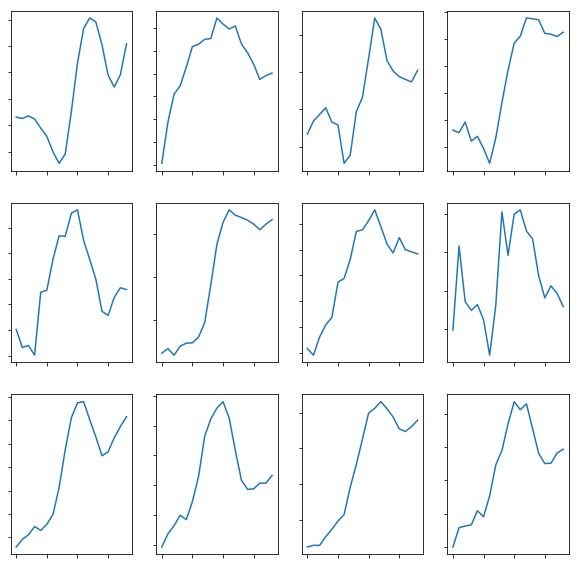

In [480]:
# plot figures for how readings change across all 12 subjects for 'HandStart' action
fig = plt.figure(12, figsize=[10,10])
for s in range(12):
    
    ax = fig.add_subplot(3,4,s+1)
    spike = get_spike(s, 0)
    xnew = np.linspace(0,len(spike),19) #300 represents number of points to make between T.min and T.max

    smooth = spline(xnew,spike,xnew)
    ax.plot(range(len(spike)), spike)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

Though the downward and upward spike is seen relatively consistently across the board, it's shape does vary considerably and apart from an overall increase in activity, a discernible pattern is not readily made out by the human eye.

In [ ]:
# some parameteres for the model
num_features = 32
window_size = 1024
batch_size=2000

In [ ]:
# Batch creator. When training it will return random locations in the dataset. The data is a time series 
# and so we feed previous readings (going back window_size) in with each index. Rather than feed in all window_size 
# previous readings, we subsample and take every 4th set of readings.

def get_batch(dataset, batch_size=2000, val=False, index=None):
    
    if val == False:
        index = random.randint(window_size, len(dataset) - 16 * batch_size)
        indexes = np.arange(index, index + 16*batch_size, 16)

    else:
        indexes = np.arange(index, index + batch_size)
    
    batch = np.zeros((batch_size, num_features, window_size//4))
    
    b = 0
    for i in indexes:
        
        start = i - window_size if i - window_size > 0 else 0
        
        tmp = dataset.data[start:i]
        batch[b,:,:] = tmp[::4].transpose()
        
        b += 1

    targets = dataset.target[indexes]
    return torch.DoubleTensor(batch), torch.DoubleTensor(targets) 

# The Model

The key to understanding which action is taking place lies in seeing the current reading in its proper context. 
So for every reading we send into our machine learning model, we will also send in readings from across a previous time window. This way the model can 'see' the shape of the wave leading up to the current event.

Convolutional neural networks (CNN) work well with time series data, so this will be our model of choice.
Though reading minds may seem like an incredibly complex art, high-level deep learning libraries like Pytorch mean we can actually code a model in 13 lines:

In [ ]:
# convolutional network model we will train to detect patterns in readings. For more information see my tutorial here.

class convmodel(nn.Module):
    
    def __init__(self, out_classes, drop=0.5, d_linear=124):
        super().__init__()
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=0, stride=1)
        self.bn = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2, stride=2)
        self.linear1 = nn.Linear(8128, d_linear)

        self.linear3 = nn.Linear(d_linear, out_classes)
        self.dropout1 = nn.Dropout(drop)
        self.dropout2 = nn.Dropout(drop)
        self.dropout3 = nn.Dropout(drop)
        
        self.conv = nn.Sequential(self.conv2, nn.ReLU(inplace=True), self.bn,\
                                    self.pool, self.dropout1) 
        self.dense = nn.Sequential(self.linear1, nn.ReLU(inplace=True),self.dropout2,\
                                    self.dropout3, self.linear3)
    def forward(self, x):
        bs = x.size(0)
        x = self.conv(x)
        x = x.view(bs, -1)
        output = self.dense(x)
        
        return torch.sigmoid(output)

The above gives the code for a simple (but effective…) CNN perfectly capable of tackling the job. 
It consists of a 1d convolutional layer, and two linear layers. While a full description of how these processes work is beyond the scope of this post, let's at least get a quick overview.

A convolutional layer simply consists of a kernel that slides along our data and applies its weights to the data values. This animation I made explains better than words alone:

<img src='images/cnn.gif'>

In reality deep learning networks will have multiple kernels, producing multiple output arrays. In the network coded above, we use 64 kernels each with their own weights, and hence produce 64 different output vectors. Each of these kernels can react to a different kind of pattern in the input.

There will also be multiple input channels (32 in fact), each one containing the previous readings for each EEG position.

The outputs from the convolutional layer are then all lined up in a single vector and put through a neural network with two layers. Here is an animation of a simple two layer neural network with three inputs, a first layer with two nodes, and a final layer with one:

<img src='images/nn.gif'>

In our neural network the process is the same though only much bigger (8128 input nodes, 124 nodes in the first layer, and 6 nodes in the final layer). There are 6 final nodes because there are 6 possible actions, and we determine an action is happening if it's corresponding node scores above a certain threshold. 

Two linear layers in a neural network is a pretty standard setup, it allows for XOR calculations (see this post) and means we don't reduce the input immediately from 8196 nodes to 6 nodes. Deciding the exact number of kernels and linear nodes is more of an art than science, and requires some fiddling around.

The weights in the convolutional kernel and the linear layers are initially random, but a process called back-propagation corrects them as we train the network on the data. For an in-depth tutorial on this process, I'd recommend Andrew Ng's free machine learning Coursera course and my tutorials.

When trained, the interactions between all these weights allows the network to detect patterns in data and make accurate predictions.

In [ ]:
model = convmodel(6).double()
if USE_CUDA == 1:
    model = model.cuda()
optim = torch.optim.Adadelta(model.parameters(), lr=1, eps=1e-10)

In [ ]:
bs = batch_size

def train(traindata, epochs, printevery=1, shuffle=True):
    
    model.train()
    
    for epoch in range(epochs):
        
        total_loss = 0
        for i in range(len(traindata)//bs):
            
            optim.zero_grad()
            x, y = get_batch(traindata)
            if USE_CUDA == 1:
                x = Variable(x).cuda()
                y = Variable(y).cuda()
            preds = model(x)
            loss = F.binary_cross_entropy(preds.view(-1), y.view(-1))
            loss.backward()
            total_loss += loss.data[0]
            optim.step()
            if (i + 1) % printevery == 0:
                print("epoch: %d, iter %d/%d, loss %.4f"%(epoch + 1, i + 1, len(traindata)//2000, total_loss/printevery), end='images/\r')
                total_loss = 0

            

In [ ]:
# train model for one epoch
train(traindata,1)

In [ ]:
# save general model
!mkdir models
torch.save(model.state_dict(), "./models/Convnet_skip4_epoch1")

# Using the model to make predictions

The below function calculates AUC scores on the validation set.

In [ ]:
def getPredictions(data):
    
    model.eval()
    
    p = []
    res = []
    i = window_size
    bs = 2000
    while i < len(data):
        
        if i + bs > len(data):
            bs = len(data) - i
             
        x, y = get_batch(data, bs, index=i, val=True, test=test)
        if USE_CUDA == 1:
            x = x.cuda()

        preds = model(x)
        preds = preds.squeeze(1)
        
        p.append(np.array(preds.data))
        res.append(np.array(y.data))

        i += bs
    
    preds = p[0]
    for i in p[1:]:
        preds = np.vstack((preds,i))
    
    targs = res[0]
    for i in res[1:]:
        targs = np.vstack((targs, i))
    
    return preds, targs

def valscore(data, test=False):
    
    
    preds, targs = getPredictions(data, test)
        
    aucs = [auc(targs[:, j], preds[:, j]) for j in range(6)]
    total_loss = np.mean(aucs)
    print(total_loss)
    
    return preds, targs   

In [ ]:
# see how we scored on validation set
valscore(valdata)

# Train individuals

So far we have trained a general model on all the data. To make predictions for each individual we will now fine tune the model on only that individual's data for one epoch. The function below loads the weights from the general model, finetunes on an individual, checks how it scores on the validation set and then saves the weights for that individual. We will use these weights later to assess our results.

In [ ]:
def train_individuals(subjects, vals):

    for i in range(12):

        model.load_state_dict(torch.load("./models/Convnet_skip4_epoch1"))
        train(subjects[i], 1)
        print('')
        valscore(vals[i])
        torch.save(model.state_dict(), "./models/subj_{}_epoch2".format(i + 1))


In [ ]:
# train general model on each subject, then get AUC score for validation set for that subject
train_individuals(subjects, vals)

# The above code yielded these scores

Best results on validation set. Trained on all data 1 epoch, then just on each subject for 1 epoch, and validated on series 3.

Subject 1
AUC score on val set: 0.959168670213603

Subject 2
AUC score on val set: 0.9505101195220913

Subject 3
AUC score on val set: 0.9219539186384723

Subject 4
AUC score on val set: 0.917931166630155

Subject 5
AUC score on val set: 0.9352121018446913

Subject 6 
AUC score on val set: 0.9419648786256208

Subject 7 
AUC score on val set: 0.9567390746916029

Subject 8
AUC score on val set: 0.8484060070332817

Subject 9
AUC score on val set: 0.9373451906678737

Subject 10
AUC score on val set: 0.9494592292374859

Subject 11
AUC score on val set: 0.9120022844956828

Subject 12
AUC score on val set: 0.9483051008950621

# Results

Running this model over all the data once (taking less than an hour) was enough for the network to discern patterns in the EEG readings and generate a validation score with 94% AUC.

However as I was to learn, 94% AUC is not the same thing as 94% accuracy. AUC is used in academia to objectively compare results as it gives a score independent of class imbalances and thresholds. In its simplest terms, it gives the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example (read more here).

Yet how does this translate into actual results? The best way to gain a true gage of how the model fared is to dig into some visuals.

Let's look at some data previously unseen by our model. In this series the subject performs the grasp and lift 28 times and the below figure shows when the subject carried out the actions (True) and when the model predicted the actions were occurring (Prediction).

In [ ]:
# let's examine the results
model.load_state_dict(torch.load("./models/subj_1_epoch2"))
preds, targs = valscore(vals[0])

In [355]:
# f is feature, and th is threshold (at which point we consider the value a positive classification). 
# In this case we are seeing how they did at 'FirstDigitTouch'. The figure shows that the model predicted 
# an action was occuring 23 of 28 times, and thought an event was occuring when it wasn't once.

def show_whole_series(f=1, th=0.3):

    ps = np.where(preds[:,f] > th)
    true = np.where(targs[:,f] == 1)
    fig = plt.figure(figsize=[15,1])
    ax1 = fig.add_subplot(1,1,1)
    ax1.scatter(ps[0]/500, ['Prediction']*len(ps[0]))
    ax1.scatter(true[0]/500, ['True']*len(true[0]))


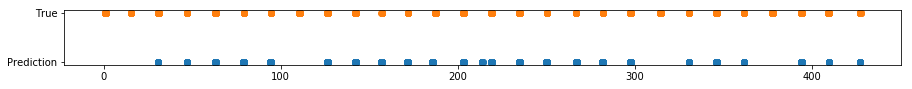

In [356]:
show_whole_series()

The model correctly predicts 23 out of the 28 lifts, and mistakenly predicts a lift when the subject isn't performing one.

If we closely examine a singular incident of the subject performing the grasp and lift, we can see how correctly the model predicted the exact action that was occurring. In the figure below we look at the third grasp and lift in the series; blue represents the prediction and orange when it actually occurred.

In [357]:
# printing some figures showing how successfully it predicted each event during a full grasp and lift sequence. This
# example looks at the third time subject 1 performed the task.

def get_indexes(data, event):
    
    start = 0
    count = 1
    for i in range(len(data)):

        if data[i + 1] > data[i] + 300:

            if event == count:
                return start, i
            start = i + 1
            count += 1

def show_results(fs=[0], trues=1, ps=[0], ths=[0.3],left=0,right=0):
    
    for i in range(len(fs)):
        
        
        f = fs[i]
        th = ths[i]
        
        p = np.where(preds[:,f] > th)
        true = np.where(targs[:,f] == 1)
        
        a_start, a_end = get_indexes(p[0], ps[i])
        t_start = trues * 150 + 150 
         
        fig2 = plt.figure(figsize=[15,1])
        ax1 = fig2.add_subplot(1,1,1)
        ax1.scatter(p[0][a_start:a_end]/500, ['Prediction']*(a_end-a_start))
        ax1.scatter(true[0][t_start:t_start+150]/500, ['True']*150)
        ax1.set_xlim(left=left, right=right)
        if left != 0 and right != 0:
            ax1.set_title(ev.columns[f + 1])
        

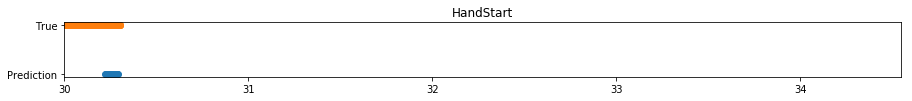

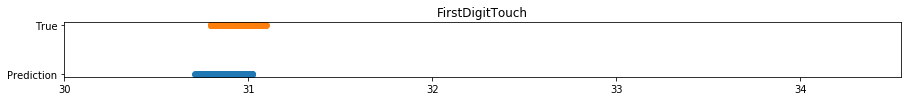

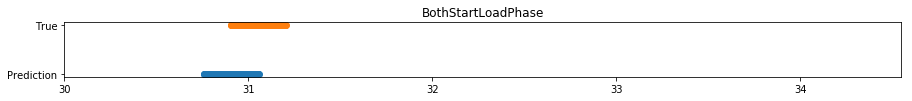

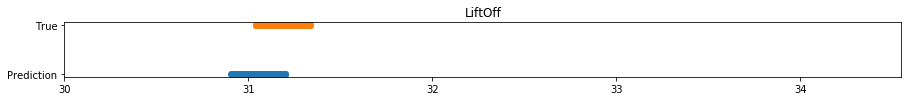

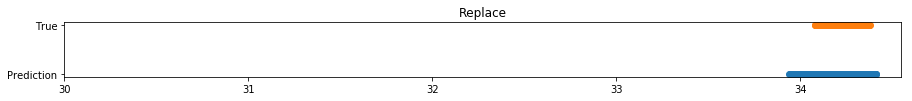

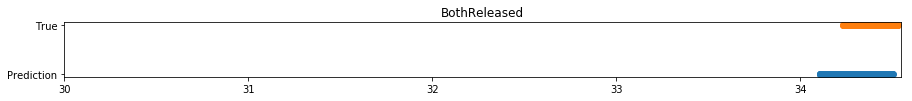

In [358]:
show_results(fs=[0,1,2,3,4,5],trues=1, ps=[1,1,1,1,2,2], ths=[0.1,0.3,0.3,0.3,0.3,0.3], left=30.0, right=34.55)

I think these results are particularly impressive. Although the predictions don't line up exactly with the data labels, this is not important in a functional sense.

The orange bars reflect a time window of +-150ms around the action, and despite the model not predicting the entire time window, it does output a correct prediction when each event actually occurs. The model could hence be used to successfully predict when an action is happening.

Notably we see the model is better at predicting the time window before the action than after it. The brain activity for a motion occurs before the movement itself, as signals start in the brain and must make their way down to the hand, so perhaps this is to be expected.

The only exception to this pattern is seen in HandStart. This event refers to when a light flashes and the subject reacts to it. In this case the nervous activity would actually occur after the light flashes and so it makes sense that our model predicts the event after it happens.